# Collect Commit Logs

In [ ]:
import json
from requests import get
from requests.auth import HTTPBasicAuth as Auth

# Parameters
USER = "" # add your github username here
TOKEN = "" # add your github token here
OWNER = "openstack"
REPO = "neutron"
SINCE = "2021-06-01T00:00:00Z"
PER_PAGE = "100"
PATH = "neutron"
COMMIT_URL = "https://api.github.com/repos/{owner}/{repo}/commits?since={since}&per_page={per_page}&path={path}".format(owner=OWNER, repo=REPO, since=SINCE, per_page=PER_PAGE, path=PATH)

url = COMMIT_URL+"&page={}"

commits = list()
page_num = 1
result = get(url.format(page_num), auth=Auth(USER, TOKEN))
body = json.loads(result.text)

while body:
  commits += body
  page_num += 1
  print("page: {}".format(page_num))
  result = get(url.format(page_num), auth=Auth(USER, TOKEN))
  body = json.loads(result.text)

with open("{owner}_{repo}_{since}.json".format(owner=OWNER, repo=REPO, since=SINCE), "w") as f:
  json.dump(commits, f, indent=4)

print("Commits Saved")

page: 2
page: 3
page: 4
page: 5
page: 6
Commits Saved


In [ ]:
print(len(commits))

472


# Get Commit Details

In [ ]:
from tqdm import tqdm
url = "https://api.github.com/repos/{owner}/{repo}/commits/".format(owner=OWNER, repo=REPO)
url += "{}"

detailed_logs = list()
for cmt in tqdm(commits):
  sha = cmt["sha"]
  result = get(url.format(sha), auth=Auth(USER, TOKEN))
  body = json.loads(result.text)
  detailed_logs.append(body)

with open("detailed_{owner}_{repo}_{since}.json".format(owner=OWNER, repo=REPO, since=SINCE), "w") as f:
  json.dump(detailed_logs, f, indent=4)

print("Detailed Commits Saved")

100%|██████████| 472/472 [01:51<00:00,  4.24it/s]

Detailed Commits Saved


# Count File Modification Status

In [ ]:
from tqdm import tqdm
add_count = dict()
delete_count = dict()
modify_count = dict()
for record in tqdm(detailed_logs):
  for file in record["files"]:
    file_name = file["filename"]
    if file_name.startswith("neutron/"):
      module = file_name.split("/")[1]
      if module.endswith(".py"):
        continue
      if module in add_count:
        add_count[module] += file["additions"]
      else:
        add_count[module] = file["additions"]
      if module in delete_count:
        delete_count[module] += file["deletions"]
      else:
        delete_count[module] = file["deletions"]
      if module in modify_count:
        modify_count[module] += file["changes"]
      else:
        modify_count[module] = file["changes"]


100%|██████████| 472/472 [00:00<00:00, 56849.05it/s]


In [ ]:
print(add_count)
print(delete_count)
print(modify_count)

{'tests': 18394, 'agent': 2886, 'common': 338, 'api': 234, 'services': 1748, 'plugins': 4265, 'objects': 722, 'cmd': 929, 'db': 4050, 'extensions': 897, 'conf': 390, 'exceptions': 48, 'privileged': 60, 'pecan_wsgi': 16, 'quota': 178, 'scheduler': 11, 'notifiers': 8, 'core_extensions': 4, 'ipam': 22, 'hacking': 4}
{'tests': 7000, 'agent': 877, 'common': 148, 'api': 151, 'services': 972, 'plugins': 2274, 'objects': 213, 'cmd': 4, 'db': 1629, 'extensions': 52, 'conf': 79, 'exceptions': 0, 'privileged': 33, 'pecan_wsgi': 36, 'quota': 382, 'scheduler': 5, 'notifiers': 6, 'core_extensions': 6, 'ipam': 12, 'hacking': 4}
{'tests': 25394, 'agent': 3763, 'common': 486, 'api': 385, 'services': 2720, 'plugins': 6539, 'objects': 935, 'cmd': 933, 'db': 5679, 'extensions': 949, 'conf': 469, 'exceptions': 48, 'privileged': 93, 'pecan_wsgi': 52, 'quota': 560, 'scheduler': 16, 'notifiers': 14, 'core_extensions': 10, 'ipam': 34, 'hacking': 8}


In [ ]:
print(len(add_count.values()))
print(sum(list(add_count.values())))
print(sum(list(delete_count.values())))
print(sum(list(modify_count.values())))

20
35204
13883
49087


# Get Top 12 Most Frequent Modifed Modules

In [ ]:
top_twelves = sorted(modify_count.items(), key=lambda x:x[1], reverse=True)[:12]

key = list()
add_val = list()
del_val = list()
mod_val = list()
for k, v in top_twelves:
  add_val.append(add_count[k])
  del_val.append(delete_count[k])
  mod_val.append(v)
  key.append(k)
  print("[{}] Add:{} + Delete:{} = Modified:{}".format(k,add_count[k],delete_count[k],v))

[tests] Add:18394 + Delete:7000 = Modified:25394
[plugins] Add:4265 + Delete:2274 = Modified:6539
[db] Add:4050 + Delete:1629 = Modified:5679
[agent] Add:2886 + Delete:877 = Modified:3763
[services] Add:1748 + Delete:972 = Modified:2720
[extensions] Add:897 + Delete:52 = Modified:949
[objects] Add:722 + Delete:213 = Modified:935
[cmd] Add:929 + Delete:4 = Modified:933
[quota] Add:178 + Delete:382 = Modified:560
[common] Add:338 + Delete:148 = Modified:486
[conf] Add:390 + Delete:79 = Modified:469
[api] Add:234 + Delete:151 = Modified:385


In [ ]:
print(sum(mod_val))

48812


# Visualize

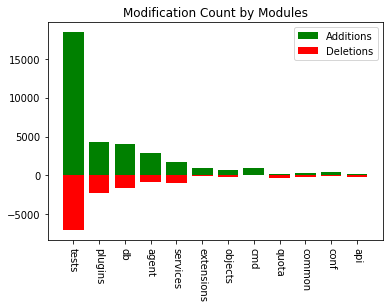

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.clf()

plt.xticks(np.arange(len(key)),key,rotation=270,fontsize=10)
plt.title("Modification Count by Modules")

plt.bar(key, add_val, color="green", label="Additions")
plt.bar(key, [-x for x in del_val], color="red", label="Deletions")

plt.legend()

plt.savefig("./modification.png", bbox_inches='tight')


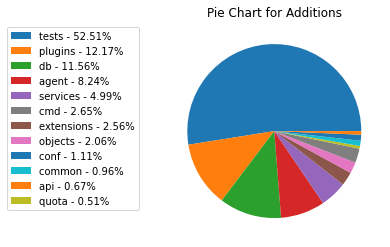

In [ ]:
add_sum = sum(add_val)
add_val = [x/add_sum for x in add_val]
add_key = [x+" - {:.2f}%".format(y*100) for x, y in zip(key, add_val)]
plt.clf()
patches, texts = plt.pie(add_val)
patches, add_key, _ =  zip(*sorted(zip(patches, add_key, add_val),key=lambda x: x[2], reverse=True))
plt.legend(patches, add_key, bbox_to_anchor=(-0.1, 1.))
plt.title("Pie Chart for Additions")

plt.savefig("addition_pie.png", bbox_inches='tight')

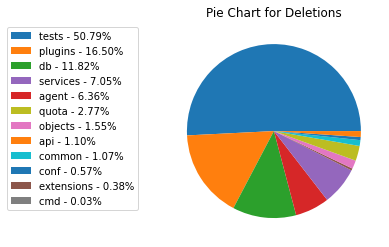

In [ ]:
del_sum = sum(del_val)
del_val = [x/del_sum for x in del_val]
del_key = [x+" - {:.2f}%".format(y*100) for x, y in zip(key, del_val)]
plt.clf()
patches, texts = plt.pie(del_val)
patches, del_key, _ =  zip(*sorted(zip(patches, del_key, del_val),key=lambda x: x[2], reverse=True))
plt.legend(patches, del_key, bbox_to_anchor=(-0.1, 1.))
plt.title("Pie Chart for Deletions")
plt.savefig("deletion_pie.png", bbox_inches='tight')